# CUPED (Controlled pre-post experimental design)

---

O CUPED  pode ser aplicado a milhates de experimentos realizados anualmente, melhorando a sensibilidade e permitindo uma avaliação mais precisa de valor, executando experimentos em amostras menores ou períodos mais curtos.

Esta técnica é aplicável a uma ampla variedade de métricas de negócio importantes e tem uma implementação prática de nível fácil.

Os resultados alcançam cerca de 50% de redução de variaância com o mesmo poder estatístico, reduzindo muito o tamanho amostral e tempo de duração.

### O que é o CUPED?

É uma técnica que utiliza dados do período pré-experimento para reduzir a variância da métrica e, portanto, alcançar melhor sensibilidade.

### Casos de uso e quando usar o CUPED?

- Existem dados confiáveis pré e durante o experimento;

- Experimentos sensíveis, com tamanho de efeito até 5%;

- Experimentos com alta variância;

- Dados pré-experimentais mais longos reduzem ainda mais a variância;

- Segundo o artigo em questão, para um experimento de 2 semanas foram utilizadas 1 semana pré-experimento e 1 pós-experimento;

- A eficâcia é reduzida quando tem muitos novos usuários no teste, tendo em vista que estes não têm dado pré-experimental;

- O p-valor pode ser visualizado ao longo do tempo com o objetivo de rejeitar H0 antes de finalizar o experimento;

- CUPED não pode ser utilizado com dados que não são do pré-experimento.

### Equação:

var(Δ) = var(Y(t) - Y(c)) = var Y(t) + var Y(c)

### Como o CUPED funciona na prática?

A variância da métrica-alvo é reduzida ajustando-se com base em covariáveis pré-existentes que sejam correlacionadas com a métrica.

> Fórmula CUPED
Dada a métrica-alvo Y e uma covariável X, o CUPED ajusta Y para produzir uma nova variável ajustada $Y_{CUPED}$, conforme:

$$
Y_{CUPED} = Y - \theta\cdot(X - \bar{X})
$$

Onde:

- Y: métrica-alvo observada.
- X: covariável pré-existente correlacionada com Y.
- $\bar{X}$: média de X.
- $\theta$: coeficiente de ajuste.

>Cálculo de $\theta$:

O coeficiente de ajuste para minimizar a variância de $Y_{CUPED}$ é dado por:

$$
\theta = \frac{\text{Cov}(Y, X)}{\text{Var}(X)}
$$

Onde:

- $\text{Cov}(Y, X)$: covariância entre Y e X.
- $\text{Var}(X)$: variância de X.

### Como funciona o ajuste?

1. Interpretando $\theta$: mede o quanto a covariável X pode ser usada para explicar a métrica Y. Quanto maior a correlação entre X e Y, maior será o impacto de X na redução da variância de $Y_{CUPED}$.

2. Centralizando X: o ajuste é feito em relação a média de X com $X - \bar{X}$, garantindo que o valor ajustado de $Y_{CUPED}$ não seja enviesado pela escala de X.

3. Redução de variância: o $Y_{CUPED}$ tem uma variância reduzida em comparação a Y, o que melhora a precisão dos resultados do experimento.

### Simulando um experimento com CUPED

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng

In [8]:
rg = default_rng(42)
n_samples = 1000

def fornece_amostras_AB(media_pre_exp, desvio_pre_exp, ruido, lift_tratamento, numero_amostras):

    a_pre_exp = list(rg.normal(loc=media_pre_exp, scale=desvio_pre_exp, size=numero_amostras))
    b_pre_exp = list(rg.normal(loc=media_pre_exp, scale=desvio_pre_exp, size=numero_amostras))

    a_pos_exp = [x + rg.normal(loc=0, scale=ruido) for x in a_pre_exp]
    b_pos_exp = [x + rg.normal(loc=0, scale=ruido) + lift_tratamento for x in a_pre_exp]

    return a_pre_exp, b_pre_exp, a_pos_exp, b_pos_exp

In [3]:
def cuped(a_pre_exp, b_pre_exp, a_pos_exp, b_pos_exp):

    apos = a_pos_exp + b_pos_exp
    antes = a_pre_exp + b_pre_exp
    covar = np.cov(apos, antes)[0,1]
    var = np.var(antes)
    theta = covar/var
    media_pre_exp = np.mean(antes)

    a_cuped = [apos - (antes - media_pre_exp) * theta for apos, antes in zip(a_pos_exp, a_pre_exp)]
    b_cuped = [apos - (antes - media_pre_exp) * theta for apos, antes in zip(b_pos_exp, b_pre_exp)]

    return a_cuped, b_cuped

In [5]:
a_pre_exp = list((rg.normal(loc=5, scale=1, size=n_samples) + rg.normal(loc=0, scale=0.001)))
b_pre_exp = list((rg.normal(loc=5, scale=1, size=n_samples) + rg.normal(loc=0, scale=0.001)))

In [6]:
lift_tratamento = 0.1

In [9]:
a_pos_exp = [x + rg.normal(loc=0, scale=0.2) for x in a_pre_exp]
b_pos_exp = [x + rg.normal(loc=0, scale=0.2) + lift_tratamento for x in a_pre_exp]

In [10]:
a_cuped, b_cuped = cuped(a_pre_exp,b_pre_exp,a_pos_exp,b_pos_exp)

In [11]:
dados = pd.DataFrame({'grupo': ['a']*1000 + ['b']*1000,
                      'valor': a_pos_exp + b_pos_exp,
                      'valor_cuped': a_cuped + b_cuped})
dados['id'] = dados.index.astype(str)
dados['data'] = pd.to_datetime(rg.choice(pd.date_range('2024-09-19', '2024-09-26'), size=2000))
dados.head()

,grupo,valor,valor_cuped,id,data
0,a,4.330991,4.678183,0,2024-09-24
1,a,4.376864,4.569697,1,2024-09-19
2,a,5.783335,5.462126,2,2024-09-21
3,a,5.190440,5.178582,3,2024-09-22
4,a,4.949337,4.772135,4,2024-09-26


In [ ]:
#Fazer teste Z com CUPED e sem CUPED

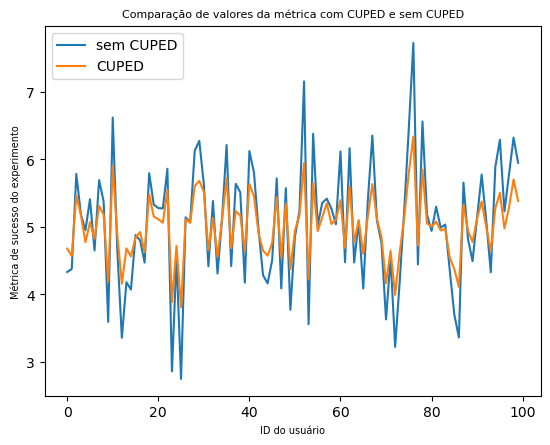

In [12]:
import matplotlib.pyplot as plt

plt.plot(dados.valor.iloc[0:100], label='sem CUPED')
plt.plot(dados.valor_cuped.iloc[0:100], label='CUPED')
plt.legend()
plt.title('Comparação de valores da métrica com CUPED e sem CUPED', size=8)
plt.xlabel('ID do usuário',size=7)
plt.ylabel('Métrica de sucesso do experimento', size=7)
plt.show()